In [1]:
import numpy             as np
import pandas            as pd
import pytorch_lightning as pl
import ML_library        as MLL
import matplotlib.pyplot as plt
import matgl
import os
import shutil
import warnings
import glob

from os                        import path
from __future__                import annotations
from dgl.data.utils            import split_dataset
from mp_api.client             import MPRester
from pytorch_lightning.loggers import CSVLogger
from matgl.ext.pymatgen        import Structure2Graph, get_element_list
from matgl.graph.data          import M3GNetDataset, MGLDataLoader, collate_fn_efs
from matgl.models              import M3GNet
from matgl.utils.training      import PotentialLightningModule

# To suppress warnings for clearer output
warnings.simplefilter('ignore')

In [2]:
data_train_path = 'm3gnet_dataset.xlsx'
model_load_path = 'M3GNet-MP-2021.2.8-PES'
model_save_path = 'finetuned_model'

# 0: material, 1: charge state, 2: ionic step
depth = 0

# Ratios for diving training data
test_ratio       = 0.2
validation_ratio = 0.2

# Number of epoch for re-training
max_epochs = 100

dpi = 100

# Load simulation data

In [7]:
# Each folder names a new column, and structure, energy, forces and stresses
# of each ionic step are loaded

if path.exists(data_train_path):
    # Load data for model training
    m3gnet_dataset = pd.read_excel(data_train_path, index_col=0, header=[0,1,2])
else:
    # Path to dataset, structured as:
    # path_to_dataset
    #     material_i
    #         defect_i
    #             simulation_i (containing vasprun.xml)
    path_to_dataset = '../../../Desktop/defects/gamma'

    # Extract the data
    source_m3gnet_dataset = MLL.extract_vaspruns_dataset(path_to_dataset)
    #source_m3gnet_dataset.to_excel(data_train_path)

source_m3gnet_dataset


BiSBr

BiSeBr

BiSeI

BiSI
	as_1_Bi_on_S_-1
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
	as_1_Bi_on_S_-2
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
	as_1_Bi_on_S_0
	as_1_Bi_on_S_1
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
	as_1_Bi_on_S_2
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
	as_1_Bi_on_S_3
Error: vasprun not correctly loaded.
	as_1_Bi_on_S_4
	as_1_Bi_on_S_5
	as_1_I_on_Bi_-1
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasp

BiSI  \
                                        BiSI_as_1_Bi_on_S_-1   
                                      BiSI_as_1_Bi_on_S_-1_0   
structure  [[3.15281399 2.93861474 5.6361836 ] Bi, [0.630...   
energy                                            -289.12365   
force      [[-1.92632264, -0.56138606, 1.59567384], [7.39...   
stress     [[-9.387791068, 0.5969766500000001, 0.44902389...   

                                                              \
                                                               
                                      BiSI_as_1_Bi_on_S_-1_1   
structure  [[3.05988314 2.91153208 5.71316315] Bi, [0.987...   
energy                                            -316.33355   
force      [[-0.90385412, -0.39068356, 1.13836959], [0.62...   
stress     [[-1.22633487, 0.35682851800000004, -0.4239112...   

                                                              \
                                                               
                                      BiSI_as_1_Bi_on_S_-1_2   
structure  [[3.05824862 2.91105576 5.71451708] Bi, [0.993...   
energy                                            -316.35309   
force      [[-0.88559512, -0.38374943, 1.12920028], [0.56...   
stress     [[-1.199570183, 0.355605151, -0.428876207], [0...   

                                                              \
                                                               
                                      BiSI_as_1_Bi_on_S_-1_3   
structure  [[3.00950645 2.89076728 5.77404553] Bi, [1.043...   
energy                                           -321.140502   
force      [[-0.35301477, -0.33939464, 0.69170336], [0.03...   
stress     [[-0.331221996, 0.340032651, -0.37534631900000...   

                                                              \
                                                               
                                      BiSI_as_1_Bi_on_S_-1_4   
structure  [[2.93082376 2.85801638 5.87013983] Bi, [1.123...   
energy                                           -324.119367   
force      [[0.40239548, -0.40297129, 0.14670017], [-0.77...   
stress     [[-0.07879467000000001, 0.310052009, -0.271773...   

                                                              \
                                                               
                                      BiSI_as_1_Bi_on_S_-1_5   
structure  [[2.93191615 2.82193713 5.90967382] Bi, [1.099...   
energy                                           -326.452302   
force      [[0.39597356, -0.26062563, -0.17949639], [-0.4...   
stress     [[-0.096809425, 0.279244603, -0.30016127400000...   

                                                              \
                                                               
                                      BiSI_as_1_Bi_on_S_-1_6   
structure  [[2.93254654 2.80111726 5.93248738] Bi, [1.085...   
energy                                           -326.847608   
force      [[0.39337901, -0.1779908, -0.3629015], [-0.342...   
stress     [[-0.24790909600000002, 0.250699222, -0.311515...   

                                                              \
                                                               
                                      BiSI_as_1_Bi_on_S_-1_7   
structure  [[2.96098326 2.77729779 5.91873229] Bi, [1.053...   
energy                                           -327.866389   
force      [[0.24801109, -0.09464026, -0.18593179], [-0.1...   
stress     [[-0.221206385, 0.236151664, -0.339607759], [0...   

                                                              \
                                                               
                                      BiSI_as_1_Bi_on_S_-1_8   
structure  [[2.98047919 2.76096739 5.909302  ] Bi, [1.031...   
energy                                           -328.058682   
force      [[0.12649111, -0.03483121, -0.06248997], [0.02...   
stress     [[-0.304339221, 0.22858141500000004, -0.350186...   

               

# Split data into train-validation-test sets

### Decide if we split in terms of mateiral, defect state or simulation directly

In [11]:
# Clone (copy) the DataFrame
m3gnet_dataset = source_m3gnet_dataset.copy()

# Remove the outer (top-level) column index up to depth-1 level
for i in range(depth):
    m3gnet_dataset.columns = m3gnet_dataset.columns.droplevel(0)

### Splitting into train-validation-test sets

In [12]:
# Check if data has been already split, else do it randomly

path_to_test_labels       = 'test_labels.txt'
path_to_validation_labels = 'validation_labels.txt'
path_to_train_labels      = 'train_labels.txt'

if path.exists(path_to_test_labels) and path.exists(path_to_validation_labels) and path.exists(path_to_train_labels):
    # Read labels splitting (which are strings)
    test_labels       = np.genfromtxt(path_to_test_labels,       dtype='str').tolist()
    validation_labels = np.genfromtxt(path_to_validation_labels, dtype='str').tolist()
    train_labels      = np.genfromtxt(path_to_train_labels,      dtype='str').tolist()
else:
    # Define unique labels, wrt the outer column
    unique_labels = np.unique(m3gnet_dataset.columns.get_level_values(0))

    # Shuffle the list of unique labels
    np.random.shuffle(unique_labels)

    # Define the sizes of every sets
    # Corresponds to the size wrt the number of unique materials in the dataset
    test_size       = int(test_ratio       * len(unique_labels))
    validation_size = int(validation_ratio * len(unique_labels))

    test_labels       = unique_labels[:test_size]
    validation_labels = unique_labels[test_size:test_size+validation_size]
    train_labels      = unique_labels[test_size+validation_size:]
    
    # Save this splitting for tranfer-learning approaches
    np.savetxt(path_to_test_labels,       test_labels,       fmt='%s')
    np.savetxt(path_to_validation_labels, validation_labels, fmt='%s')
    np.savetxt(path_to_train_labels,      train_labels,      fmt='%s')

# Use the loaded/computed labels to generate split datasets
test_dataset       = m3gnet_dataset[test_labels]
validation_dataset = m3gnet_dataset[validation_labels]
train_dataset      = m3gnet_dataset[train_labels]

n_test       = np.shape(test_dataset)[1]
n_validation = np.shape(validation_dataset)[1]
n_train      = np.shape(train_dataset)[1]

print(f'Using {n_train} samples to train, {n_validation} to evaluate, and {n_test} to test')

Using 7962 samples to train, 2543 to evaluate, and 2409 to test


In [ ]:
test_labels, validation_labels, train_labels

In [13]:
all_data = []
for i in range(3):  # Iterate over train-validation-test sets
    name    = ['train', 'val', 'test'][i]
    dataset = [train_dataset, validation_dataset, test_dataset][i]
    
    # Extract data from dataset
    labels = {
        "energies": dataset.loc['energy'].values.tolist(),
        "forces":   dataset.loc['force'].values.tolist(),
        "stresses": dataset.loc['stress'].values.tolist(),
    }
    
    structures    = dataset.loc['structure'].values.tolist()
    element_types = get_element_list(structures)
    converter     = Structure2Graph(element_types=element_types, cutoff=5.0)
    
    # Generate dataset
    data = M3GNetDataset(
        filename=f'dgl_graph-{name}.bin',
        filename_line_graph=f'dgl_line_graph-{name}.bin',
        filename_state_attr=f'state_attr-{name}.pt',
        filename_labels=f'labels-{name}.json',
        threebody_cutoff=4.0,
        structures=structures,
        converter=converter,
        labels=labels,
        name=f'M3GNetDataset-{name}',
    )
    all_data.append(data)

train_data, val_data, test_data = all_data

7962
2543


100%|███████████████████████████████████████| 2543/2543 [00:41<00:00, 61.05it/s]


2409


100%|███████████████████████████████████████| 2409/2409 [00:44<00:00, 54.54it/s]


In [14]:
train_loader, val_loader, test_loader = MGLDataLoader(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    collate_fn=collate_fn_efs,
    batch_size=2,
    num_workers=1,
)
model = M3GNet(
    element_types=element_types,
    is_intensive=False,
)
lit_module = PotentialLightningModule(model=model)

# Retrain model

In [15]:
# download a pre-trained M3GNet
m3gnet_nnp          = matgl.load_model(model_load_path)
model_pretrained    = m3gnet_nnp.model
lit_module_finetune = PotentialLightningModule(model=model_pretrained, lr=1e-4)

In [ ]:
# If you wish to disable GPU or MPS (M1 mac) training, use the accelerator='cpu' kwarg.
# accelerator='auto' selects the appropriate Accelerator
logger  = CSVLogger('logs',
                    name='M3GNet_finetuning')

trainer = pl.Trainer(max_epochs=max_epochs,
                     accelerator='auto',
                     logger=logger,
                     inference_mode=False)

trainer.fit(model=lit_module_finetune,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader
           )

# Save trained model
model_pretrained.save(model_save_path)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | mae   | MeanAbsoluteError | 0     
1 | rmse  | MeanSquaredError  | 0     
2 | model | Potential         | 288 K 
--------------------------------------------
288 K     Trainable params
0         Non-trainable params
288 K     Total params
1.153     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Analyze metrics

In [17]:
trainer.test(model=lit_module_finetune,
            dataloaders=test_loader
           )

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_Energy_MAE        0.13750533759593964
    test_Energy_RMSE        0.13759809732437134
     test_Force_MAE        0.035484496504068375
     test_Force_RMSE        0.0501679889857769
   test_Site_Wise_MAE               0.0
   test_Site_Wise_RMSE              0.0
     test_Stress_MAE                0.0
    test_Stress_RMSE                0.0
     test_Total_Loss       0.028053998947143555
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_Total_Loss': 0.028053998947143555,
  'test_Energy_MAE': 0.13750533759593964,
  'test_Force_MAE': 0.035484496504068375,
  'test_Stress_MAE': 0.0,
  'test_Site_Wise_MAE': 0.0,
  'test_Energy_RMSE': 0.13759809732437134,
  'test_Force_RMSE': 0.0501679889857769,
  'test_Stress_RMSE': 0.0,
  'test_Site_Wise_RMSE': 0.0}]

In [18]:
# Version of trainng you specifically want to analyze
current_version = 0

# Read the CSV file
path_to_csv = f'logs/M3GNet_finetuning/version_{current_version}'
df = pd.read_csv(f'{path_to_csv}/metrics.csv')
df

,val_Total_Loss,val_Energy_MAE,val_Force_MAE,val_Stress_MAE,val_Site_Wise_MAE,val_Energy_RMSE,val_Force_RMSE,val_Stress_RMSE,val_Site_Wise_RMSE,epoch,...,train_Site_Wise_RMSE,test_Total_Loss,test_Energy_MAE,test_Force_MAE,test_Stress_MAE,test_Site_Wise_MAE,test_Energy_RMSE,test_Force_RMSE,test_Stress_RMSE,test_Site_Wise_RMSE
0,0.042108,0.113924,0.075427,0.0,0.0,0.114135,0.109256,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.033011,0.102970,0.063402,0.0,0.0,0.103049,0.091366,0.0,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.029573,0.106461,0.054667,0.0,0.0,0.106558,0.080781,0.0,0.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.045462,0.156790,0.047148,0.0,0.0,0.156917,0.068586,0.0,0.0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.026420,0.104836,0.046680,0.0,0.0,0.104927,0.067189,0.0,0.0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# NaN to cero
df = df.fillna(0)

# Calculate the sum of every two consecutive rows
df = df.groupby(df.index // 2).sum()

df

,val_Total_Loss,val_Energy_MAE,val_Force_MAE,val_Stress_MAE,val_Site_Wise_MAE,val_Energy_RMSE,val_Force_RMSE,val_Stress_RMSE,val_Site_Wise_RMSE,epoch,...,train_Site_Wise_RMSE,test_Total_Loss,test_Energy_MAE,test_Force_MAE,test_Stress_MAE,test_Site_Wise_MAE,test_Energy_RMSE,test_Force_RMSE,test_Stress_RMSE,test_Site_Wise_RMSE
0,0.042108,0.113924,0.075427,0.0,0.0,0.114135,0.109256,0.0,0.0,0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
1,0.033011,0.102970,0.063402,0.0,0.0,0.103049,0.091366,0.0,0.0,2,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
2,0.029573,0.106461,0.054667,0.0,0.0,0.106558,0.080781,0.0,0.0,4,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
3,0.045462,0.156790,0.047148,0.0,0.0,0.156917,0.068586,0.0,0.0,6,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
4,0.026420,0.104836,0.046680,0.0,0.0,0.104927,0.067189,0.0,0.0,8,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
5,0.036250,0.130829,0.047389,0.0,0.0,0.130957,0.068873,0.0,0.0,10,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
6,0.026097,0.109450,0.044264,0.0,0.0,0.109525,0.063824,0.0,0.0,12,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
7,0.024742,0.104797,0.041700,0.0,0.0,0.104848,0.060838,0.0,0.0,14,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
8,0.025517,0.104468,0.041915,0.0,0.0,0.104526,0.063300,0.0,0.0,16,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
9,0.027267,0.109637,0.041474,0.0,0.0,0.109694,0.060999,0.0,0.0,18,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


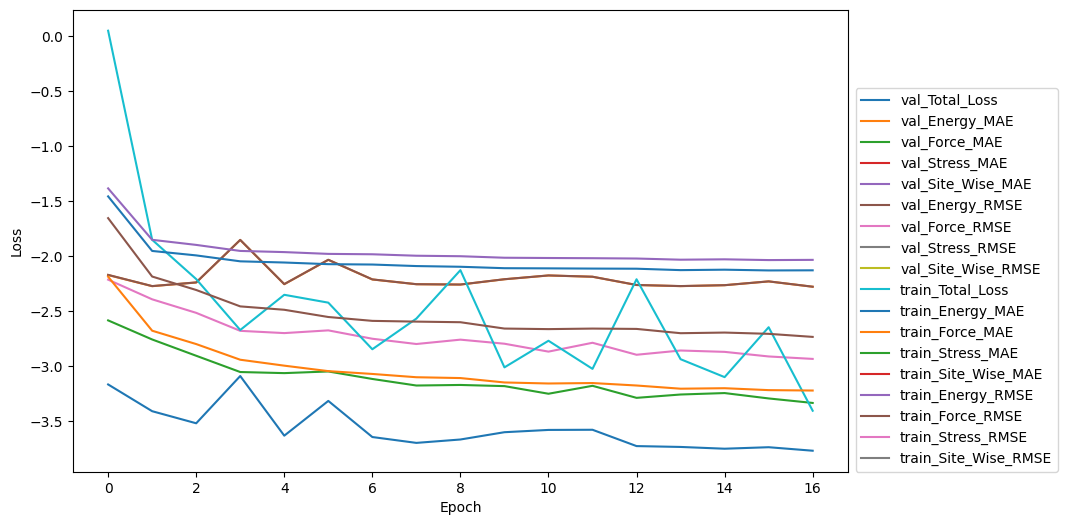

In [20]:
# Get the list of loss column names
loss_columns = [col for col in df.columns if col.startswith('val_') or col.startswith('train_')]

# Create a figure and axis
fig = plt.subplots(figsize=(10, 6))

# Plot each loss
for loss_column in loss_columns:
    plt.plot(df.index, np.log(df[loss_column]), label=loss_column)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=(1.01, 0))
plt.savefig(f'm3gnet_loss.eps', dpi=dpi, bbox_inches='tight')
plt.show()

In [21]:
df['val_Energy_MAE'].iloc[-1], df['val_Force_MAE'].iloc[-1], df['val_Stress_MAE'].iloc[-1]

(0.0, 0.0, 0.0)

# Cleanup the notebook

In [ ]:
# This code just performs cleanup for this notebook from temporal files

patterns = ['dgl_graph*.bin', 'dgl_line_graph*.bin', 'state_attr*.pt', 'labels*.json']
for pattern in patterns:
    files = glob.glob(pattern)
    for file in files:
        try:
            os.remove(file)
        except FileNotFoundError:
            pass

#shutil.rmtree('logs')
#shutil.rmtree('trained_model')
#shutil.rmtree('finetuned_model')